In [1]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
import tensorflow as tf
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import VGG16, DenseNet169
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
#from classification_models.tfkeras import Classifiers
from datetime import datetime
%load_ext tensorboard

In [3]:
EPOCHS =50
INIT_LR = 0.0001
BS =32
default_image_size = tuple((50, 50))
image_size = 0
width=50
height=50
depth=3
train_dir=r"D:\DP\Ashish sec\Augmented C.B\ham"
#valid_dir=r"C:\Users\Glau\Desktop\DP\Pediastrum_cnn\Test"
train_folder=listdir(train_dir)
#valid_folder=listdir(valid_dir)

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
train_image_list, train_image_label=[],[]
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpeg") == True or image_directory.endswith(".jpg") == True or  image_directory.endswith(".png") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing AC ...
processing CT ...
processing KAM ...
processing LYN ...
processing MIC ...
processing NOS ...
processing OS ...
processing PAM ...
processing PTE ...
processing SCY ...
[INFO] Image loading completed


In [6]:
print(len(train_image_label))

17750


In [7]:
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
#bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_burn_labelHAM.pk', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:
print(len(bin_train_image_labels))

17750


In [9]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0

In [10]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [11]:
# coding: utf8
from tensorflow.keras import layers
from tensorflow.keras import models


#
# image dimensions
#

img_height = 50
img_width = 50
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(8, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):#3
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 64, 128, _project_shortcut=project_shortcut)

    # conv3
    #for i in range(4):#4
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
       # strides = (2, 2) if i == 0 else (1, 1)
       # x = residual_block(x, 128, 256, _strides=strides)

    # conv4
    #for i in range(6):#6
       # strides = (2, 2) if i == 0 else (1, 1)
       # x = residual_block(x, 256, 512, _strides=strides)

    # conv5
   # for i in range(3):#3
       # strides = (2, 2) if i == 0 else (1, 1)
       # x = residual_block(x, 512, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(10,activation='softmax')(x)

    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 25, 8)    608         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 25, 25, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 25, 25, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

[INFO] training network...


In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

In [14]:
conf_matrix_list_of_arrays = []
#loss_per_fold = []
seed = 13   # for reproducibility you can change it. 
np.random.seed(seed)
roundlabel=[]
test=[]
idtest=[]
x_validate=[]
kfold = KFold(5, True, seed)
for train_idx, val_idx in kfold.split(np_train_image_list, y=bin_train_image_labels):
    #print('train: %s, val: %s' % (train_idx, val_idx))
    x_train, x_val = np_train_image_list[train_idx], np_train_image_list[val_idx]
    y_train, y_val= bin_train_image_labels[train_idx], bin_train_image_labels[val_idx]
    history=model.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )
    ycalculated = model.predict(x_val)
    yhat_classes =np.argmax(ycalculated,axis=1)
    rounded_labels=np.argmax(y_val,axis=1)                           
    conf_matrix = confusion_matrix(rounded_labels,yhat_classes)
    conf_matrix_list_of_arrays .append(conf_matrix)
    roundlabel.append(rounded_labels)
    test.append(yhat_classes)
    idtest.append(val_idx)
    
print('Score per fold')
for i in range(0, len(conf_matrix_list_of_arrays)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1}  - Accuracy: {conf_matrix_list_of_arrays[i]}%')   

Train on 14200 samples, validate on 3550 samples
Epoch 1/50
14200/14200 [==============================] - 40s 3ms/sample - loss: 1.9329 - accuracy: 0.3599 - val_loss: 1.9290 - val_accuracy: 0.3406
Epoch 2/50
14200/14200 [==============================] - 28s 2ms/sample - loss: 1.4499 - accuracy: 0.5365 - val_loss: 1.3054 - val_accuracy: 0.5786
Epoch 3/50
14200/14200 [==============================] - 25s 2ms/sample - loss: 1.2389 - accuracy: 0.6013 - val_loss: 1.2379 - val_accuracy: 0.5682
Epoch 4/50
14200/14200 [==============================] - 26s 2ms/sample - loss: 1.1131 - accuracy: 0.6351 - val_loss: 1.0110 - val_accuracy: 0.6744
Epoch 5/50
14200/14200 [==============================] - 27s 2ms/sample - loss: 1.0189 - accuracy: 0.6593 - val_loss: 0.9510 - val_accuracy: 0.6882
Epoch 6/50
14200/14200 [==============================] - 27s 2ms/sample - loss: 0.9488 - accuracy: 0.6802 - val_loss: 0.8051 - val_accuracy: 0.7208
Epoch 7/50
14200/14200 [==============================] -

14200/14200 [==============================] - 18s 1ms/sample - loss: 0.1096 - accuracy: 0.9688 - val_loss: 0.1232 - val_accuracy: 0.9710
Epoch 6/50
14200/14200 [==============================] - 18s 1ms/sample - loss: 0.1033 - accuracy: 0.9716 - val_loss: 0.0573 - val_accuracy: 0.9854
Epoch 7/50
14200/14200 [==============================] - 19s 1ms/sample - loss: 0.1022 - accuracy: 0.9718 - val_loss: 0.0717 - val_accuracy: 0.9792
Epoch 8/50
14200/14200 [==============================] - 19s 1ms/sample - loss: 0.0935 - accuracy: 0.9763 - val_loss: 0.0359 - val_accuracy: 0.9955
Epoch 9/50
14200/14200 [==============================] - 19s 1ms/sample - loss: 0.1052 - accuracy: 0.9704 - val_loss: 0.0471 - val_accuracy: 0.9921
Epoch 10/50
14200/14200 [==============================] - 19s 1ms/sample - loss: 0.1012 - accuracy: 0.9718 - val_loss: 0.0398 - val_accuracy: 0.9935
Epoch 11/50
14200/14200 [==============================] - 18s 1ms/sample - loss: 0.0908 - accuracy: 0.9755 - val_lo

14200/14200 [==============================] - 27s 2ms/sample - loss: 0.0276 - accuracy: 0.9929 - val_loss: 0.0213 - val_accuracy: 0.9941
Epoch 14/50
14200/14200 [==============================] - 27s 2ms/sample - loss: 0.0229 - accuracy: 0.9942 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 15/50
14200/14200 [==============================] - 28s 2ms/sample - loss: 0.0252 - accuracy: 0.9937 - val_loss: 0.0040 - val_accuracy: 0.9994
Epoch 16/50
14200/14200 [==============================] - 28s 2ms/sample - loss: 0.0302 - accuracy: 0.9920 - val_loss: 0.0047 - val_accuracy: 0.9997
Epoch 17/50
14200/14200 [==============================] - 27s 2ms/sample - loss: 0.0226 - accuracy: 0.9945 - val_loss: 0.0472 - val_accuracy: 0.9837
Epoch 18/50
14200/14200 [==============================] - 27s 2ms/sample - loss: 0.0262 - accuracy: 0.9930 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 19/50
14200/14200 [==============================] - 28s 2ms/sample - loss: 0.0302 - accuracy: 0.9914 - va

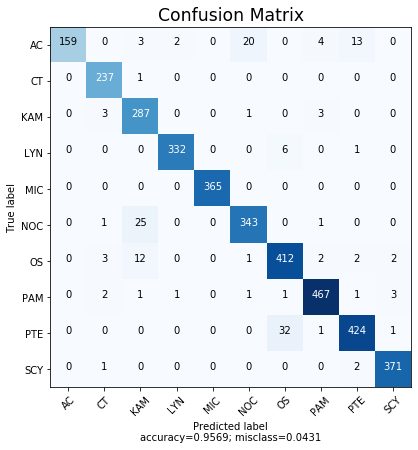

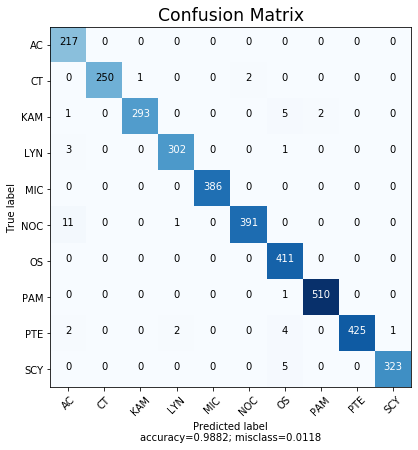

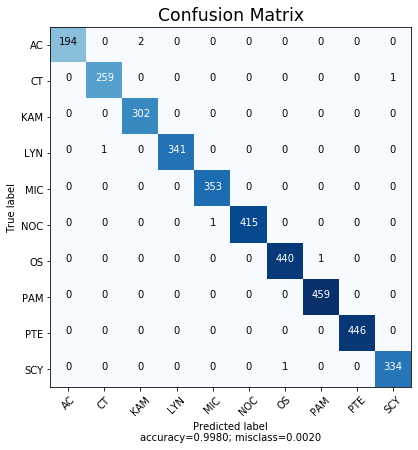

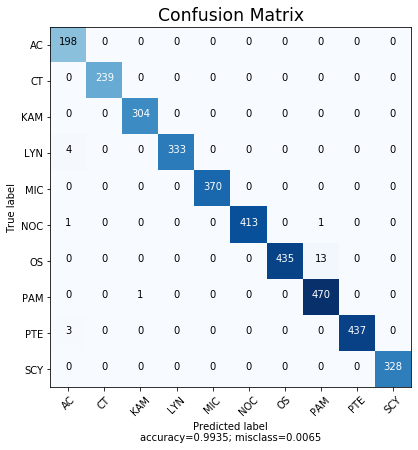

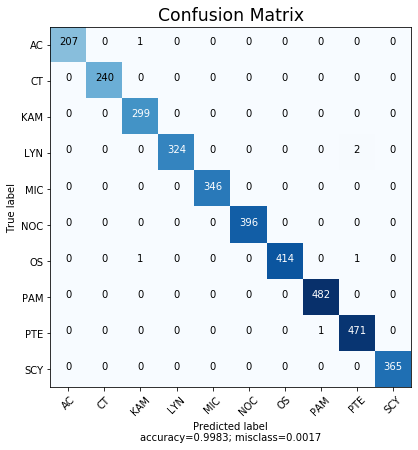

In [15]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
for i in range(5):
    plot_confusion_matrix(conf_matrix_list_of_arrays[i], 
                      normalize = False,
                      target_names = ['AC', 'CT', 'KAM','LYN','MIC','NOC','OS','PAM','PTE','SCY'],
                      title        = "Confusion Matrix")

In [16]:
class_to_label_map={0:'AC',1: 'CT', 2:'KAM',3:'LYN',4:'MIC',5:'NOC',6:'OS',7:'PAM',8:'PTE',9:'SCY' }

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


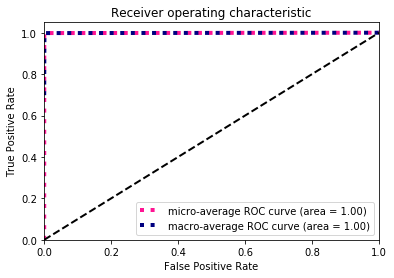

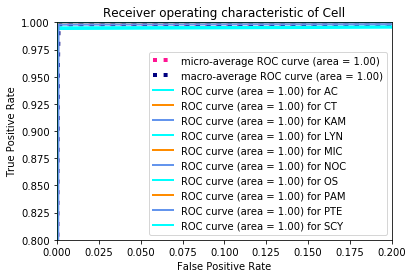

In [17]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes =10

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
lb = LabelBinarizer()
lb.fit(rounded_labels)
y_test= lb.transform(rounded_labels)
snn_pred = lb.transform(yhat_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw,color='white')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Cell')
plt.legend(loc="lower right")
plt.show()


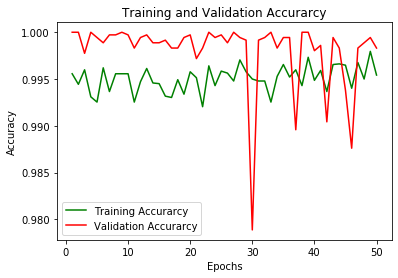

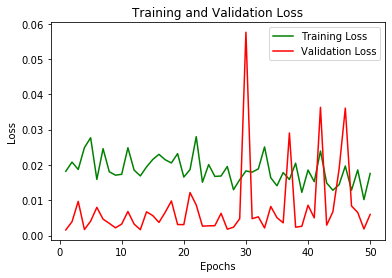

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
np.random.seed(1000)
#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=8, input_shape=(224,224,3), kernel_size=(5,5), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(50*50*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
#model.add(Dense(1000))
#model.add(Activation('relu'))
# Add Dropout
#model.add(Dropout(0.4))

# Output Layer
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

# Compile the model
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])

ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_13_1/convolution' (op: 'Conv2D') with input shapes: [?,1,1,16], [3,3,16,64].

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

In [21]:
conf_matrix_list_of_arrays = []
#loss_per_fold = []
seed = 13   # for reproducibility you can change it. 
np.random.seed(seed)
roundlabel=[]
test=[]
idtest=[]
x_validate=[]
kfold = KFold(5, True, seed)
for train_idx, val_idx in kfold.split(np_train_image_list, y=bin_train_image_labels):
    #print('train: %s, val: %s' % (train_idx, val_idx))
    x_train, x_val = np_train_image_list[train_idx], np_train_image_list[val_idx]
    y_train, y_val= bin_train_image_labels[train_idx], bin_train_image_labels[val_idx]
    history=model.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )
    ycalculated = model.predict(x_val)
    yhat_classes =np.argmax(ycalculated,axis=1)
    rounded_labels=np.argmax(y_val,axis=1)                           
    conf_matrix = confusion_matrix(rounded_labels,yhat_classes)
    conf_matrix_list_of_arrays .append(conf_matrix)
    roundlabel.append(rounded_labels)
    test.append(yhat_classes)
    idtest.append(val_idx)
    
print('Score per fold')
for i in range(0, len(conf_matrix_list_of_arrays)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1}  - Accuracy: {conf_matrix_list_of_arrays[i]}%')   

Train on 14200 samples, validate on 3550 samples
Epoch 1/30
14200/14200 [==============================] - 28s 2ms/sample - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.1573 - val_accuracy: 0.9811
Epoch 2/30
14200/14200 [==============================] - 28s 2ms/sample - loss: 0.0015 - accuracy: 0.9996 - val_loss: 1.3894e-04 - val_accuracy: 1.0000
Epoch 3/30
14200/14200 [==============================] - 27s 2ms/sample - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0827 - val_accuracy: 0.9654
Epoch 4/30
14200/14200 [==============================] - 27s 2ms/sample - loss: 0.0016 - accuracy: 0.9996 - val_loss: 1.6984e-04 - val_accuracy: 1.0000
Epoch 5/30
14200/14200 [==============================] - 25s 2ms/sample - loss: 0.0032 - accuracy: 0.9991 - val_loss: 4.9689e-04 - val_accuracy: 1.0000
Epoch 6/30
14200/14200 [==============================] - 27s 2ms/sample - loss: 0.0028 - accuracy: 0.9994 - val_loss: 3.2811e-04 - val_accuracy: 1.0000
Epoch 7/30
14200/14200 [=================

14200/14200 [==============================] - 27s 2ms/sample - loss: 4.2349e-04 - accuracy: 1.0000 - val_loss: 3.4424e-05 - val_accuracy: 1.0000
Epoch 16/30
14200/14200 [==============================] - 29s 2ms/sample - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0028 - val_accuracy: 0.9994
Epoch 17/30
14200/14200 [==============================] - 29s 2ms/sample - loss: 7.0499e-04 - accuracy: 0.9999 - val_loss: 3.0601e-05 - val_accuracy: 1.0000
Epoch 18/30
14200/14200 [==============================] - 29s 2ms/sample - loss: 9.5850e-04 - accuracy: 0.9998 - val_loss: 0.0020 - val_accuracy: 0.9992
Epoch 19/30
14200/14200 [==============================] - 27s 2ms/sample - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0014 - val_accuracy: 0.9994
Epoch 20/30
14200/14200 [==============================] - 28s 2ms/sample - loss: 8.1199e-04 - accuracy: 0.9999 - val_loss: 4.1443e-05 - val_accuracy: 1.0000
Epoch 21/30
14200/14200 [==============================] - 26s 2ms/sample - loss: 6.

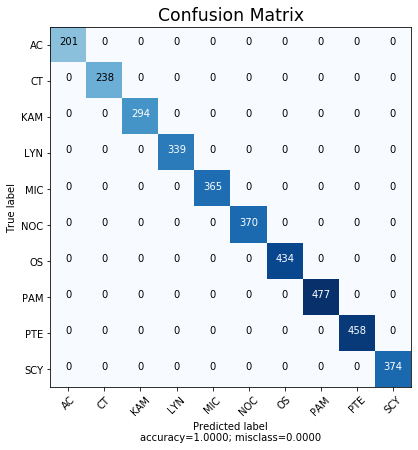

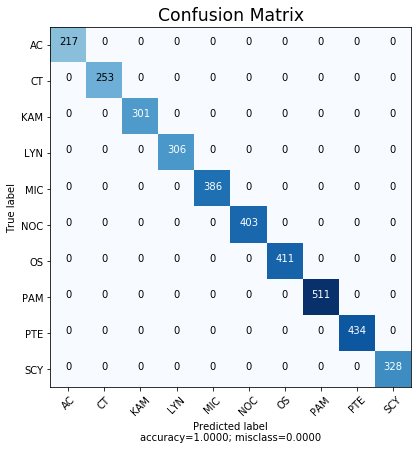

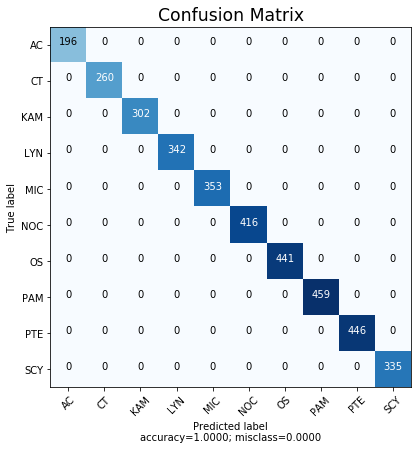

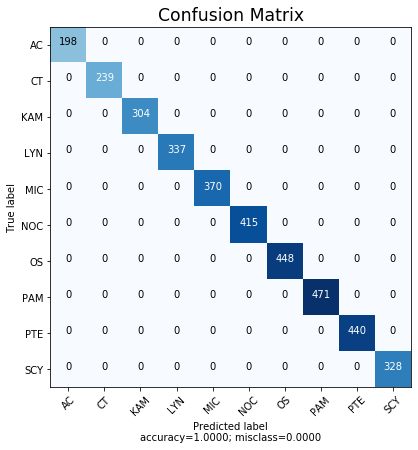

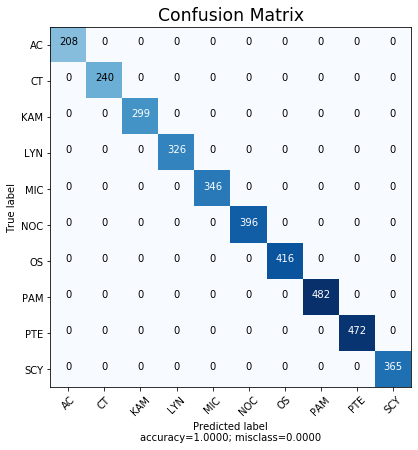

In [22]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
for i in range(5):
    plot_confusion_matrix(conf_matrix_list_of_arrays[i], 
                      normalize = False,
                      target_names = ['AC', 'CT', 'KAM','LYN','MIC','NOC','OS','PAM','PTE','SCY'],
                      title        = "Confusion Matrix")

In [23]:
class_to_label_map={0:'AC',1: 'CT', 2:'KAM',3:'LYN',4:'MIC',5:'NOC',6:'OS',7:'PAM',8:'PTE',9:'SCY' }

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


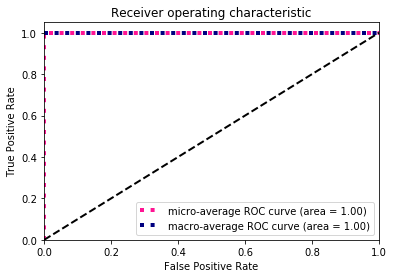

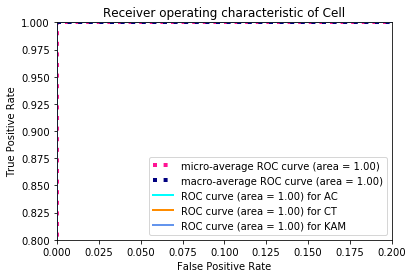

In [24]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes =10

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
lb = LabelBinarizer()
lb.fit(rounded_labels)
y_test= lb.transform(rounded_labels)
snn_pred = lb.transform(yhat_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(10, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw,color='white')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Cell')
plt.legend(loc="lower right")
plt.show()


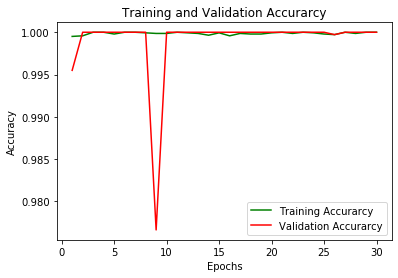

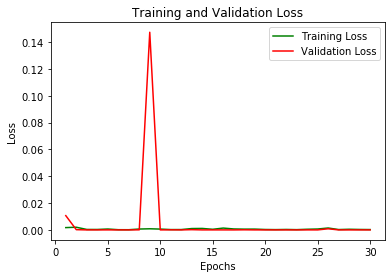

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
#vgg16
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model

_input = Input((50,50,3)) 

conv1  = Conv2D(filters=64, kernel_size=(7,7), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(10, activation="softmax")(dense1)


model  = Model(inputs=_input, outputs=output)

Using TensorFlow backend.


In [19]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

[INFO] training network...


In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

In [23]:
conf_matrix_list_of_arrays = []
#loss_per_fold = []
seed = 13   # for reproducibility you can change it. 
np.random.seed(seed)
roundlabel=[]
test=[]
idtest=[]
x_validate=[]
kfold = KFold(5, True, seed)
for train_idx, val_idx in kfold.split(np_train_image_list, y=bin_train_image_labels):
    #print('train: %s, val: %s' % (train_idx, val_idx))
    x_train, x_val = np_train_image_list[train_idx], np_train_image_list[val_idx]
    y_train, y_val= bin_train_image_labels[train_idx], bin_train_image_labels[val_idx]
    history=model.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )
    ycalculated = model.predict(x_val)
    yhat_classes =np.argmax(ycalculated,axis=1)
    rounded_labels=np.argmax(y_val,axis=1)                           
    conf_matrix = confusion_matrix(rounded_labels,yhat_classes)
    conf_matrix_list_of_arrays .append(conf_matrix)
    roundlabel.append(rounded_labels)
    test.append(yhat_classes)
    idtest.append(val_idx)
    
print('Score per fold')
for i in range(0, len(conf_matrix_list_of_arrays)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1}  - Accuracy: {conf_matrix_list_of_arrays[i]}%')   

AttributeError: 'Sequential' object has no attribute '_feed_output_names'

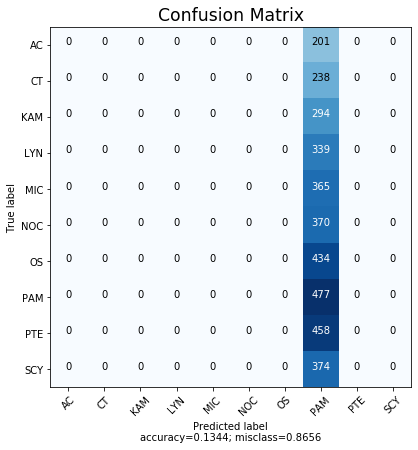

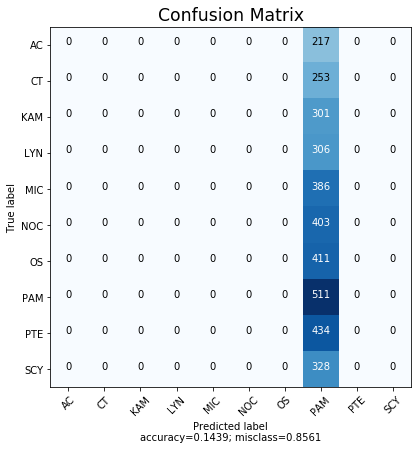

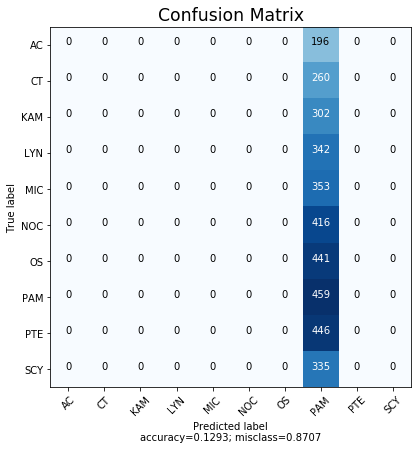

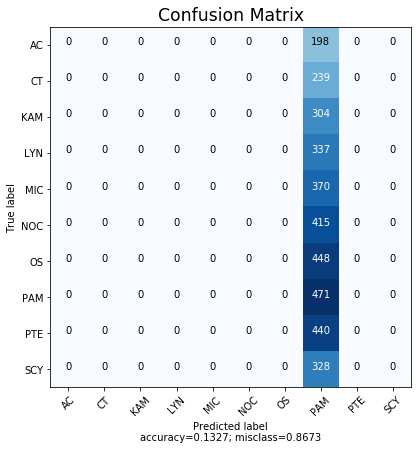

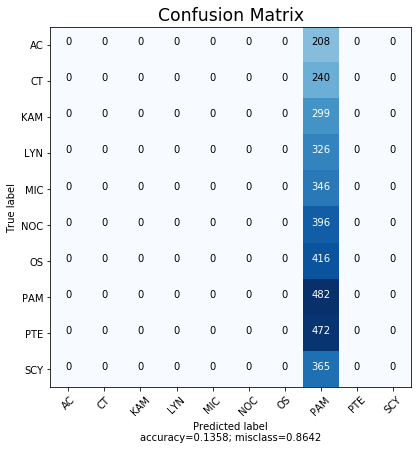

In [30]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
for i in range(5):
    plot_confusion_matrix(conf_matrix_list_of_arrays[i], 
                      normalize = False,
                      target_names = ['AC', 'CT', 'KAM','LYN','MIC','NOC','OS','PAM','PTE','SCY'],
                      title        = "Confusion Matrix")

In [31]:
class_to_label_map={0:'AC',1: 'CT', 2:'KAM',3:'LYN',4:'MIC',5:'NOC',6:'OS',7:'PAM',8:'PTE',9:'SCY' }

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


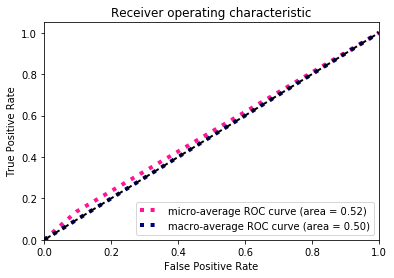

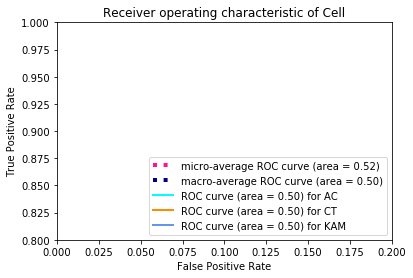

In [32]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes =10

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
lb = LabelBinarizer()
lb.fit(rounded_labels)
y_test= lb.transform(rounded_labels)
snn_pred = lb.transform(yhat_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw,color='white')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Cell')
plt.legend(loc="lower right")
plt.show()


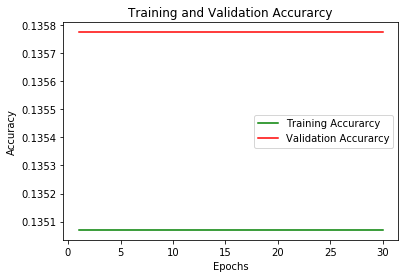

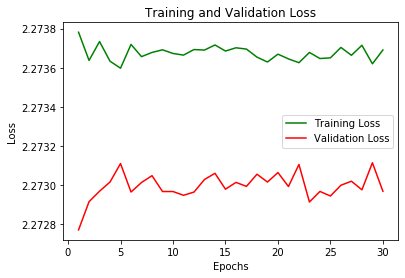

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
model.save("model_HAM.h5")

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
